In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
sns.set_palette('muted')

## Contents
1. [Load & Visualize Time Series](#load_viz)
2. [Change Point Detection](#cpd)
3. [Autocorrelation Functions (ACF/PACF)](#acf_pacf)
4. [ARIMA Modeling](#arima_modeling), [ARIMA Forecasting](#arima_forecasting)
5. [Exogenous Variables](#exog)
6. [Modeling with Exogenous Variables](#exog_modeling), [Forecasting with Exogenous Variables](#exog_forecasting)

<a id='load_viz'></a>
## Load & Visualize Time Series

In [2]:
df_orig = pd.read_json('df.json', orient='split')
print(df_orig.info())
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981 entries, 0 to 2980
Data columns (total 16 columns):
date              2981 non-null datetime64[ns]
eth_open          1134 non-null float64
eth_high          1134 non-null float64
eth_low           1134 non-null float64
eth_close         1134 non-null float64
eth_volumefrom    1134 non-null float64
eth_volumeto      1134 non-null float64
btc               2981 non-null float64
xrp               1332 non-null float64
eos               442 non-null float64
ltc               1786 non-null float64
xlm               605 non-null float64
xmr               1324 non-null float64
vixcls            2981 non-null float64
twexb             2981 non-null float64
effr              2981 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 395.9 KB
None


,date,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr
0,2010-07-16,NaN,NaN,NaN,NaN,NaN,NaN,0.04951,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19
1,2010-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.08584,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19
2,2010-07-18,NaN,NaN,NaN,NaN,NaN,NaN,0.08080,NaN,NaN,NaN,NaN,NaN,26.25,103.1938,0.19


In [3]:
# set df for time series
df = df_orig[['date', 'eth_close']]
df.rename(columns={'eth_close':'eth'}, inplace=True)

# start at the beginning of ethereum
df = df[df.eth.isnull().sum():]
df.set_index('date', inplace=True)
df.head()

,eth
date,
2015-08-06,3.00
2015-08-07,1.20
2015-08-08,1.20
2015-08-09,1.20
2015-08-10,0.99


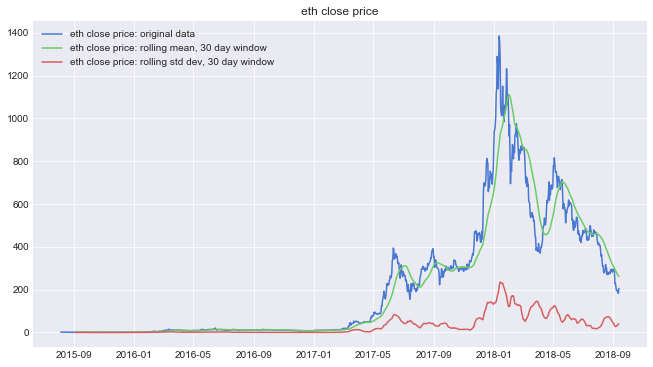

adf: -1.8088972361212996
pval: 0.37605349542421385
critical vals {'1%': -3.4362549432361504, '5%': -2.8641473395601595, '10%': -2.568158225793361}


In [4]:
plt.figure(figsize=(11,6))
plt.plot(
    df.index.values,
    df.eth,
    label='eth close price: original data'
)
plt.plot(
    df.index.values,
    df.eth.rolling(30).mean(),
    label='eth close price: rolling mean, 30 day window'
)
plt.plot(
    df.index.values,
    df.eth.rolling(30).std(),
    label='eth close price: rolling std dev, 30 day window'
)
plt.title('eth close price')
plt.legend(loc='upper left')
plt.show()

from statsmodels.tsa.stattools import adfuller
print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(df.eth)[0],
    adfuller(df.eth)[1],
    adfuller(df.eth)[4]))

**Interpretation:**
- Data displays trend
- Graph indicates presence of structural breaks
- Data does not show stationarity
- ADF test confirms data is not stationary

<a id='cpd'></a>
## Change Point Detection
- [Ruptures Library](https://github.com/deepcharles/ruptures) used for change point detection
- Pruned Exact Linear Time (PELT): penalized change point detection algorithm

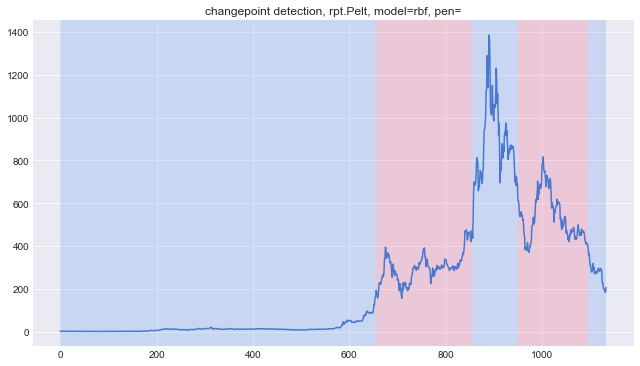

[655, 855, 950, 1095, 1134]
len: 5


In [5]:
import ruptures as rpt
cpts = rpt.Pelt(model='rbf').fit_predict(df, pen=20)

rpt.display(df, cpts, figsize=(9,5))
plt.title('changepoint detection, rpt.Pelt, model=rbf, pen=')
plt.show()
print(cpts)
print('len: {}'.format(len(cpts)))

In [6]:
# split df by changepoints
df_01 = df[:cpts[0]]
df_02 = df[cpts[0]:cpts[1]]
df_03 = df[cpts[1]:cpts[2]]
df_04 = df[cpts[2]:cpts[3]]
df_05 = df[cpts[3]:]

In [7]:
# a few attempts at stationarity
df_05['diff_1'] = df_05.eth - df_05.eth.shift(1)
df_05['diff_2'] = df_05.eth - df_05.eth.shift(2)
df_05['log'] = np.log(df_05.eth)
df_05['log_diff_1'] = np.log(df_05.eth).diff().dropna()
df_05['sqrt'] = np.sqrt(df_05.eth)

# drop nans from differencing
#df_05 = df_05[2:]

print('\ndiff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.diff_1[2:])[0],
    adfuller(df_05.diff_1[2:])[1],
    adfuller(df_05.diff_1[2:])[4]))

print('\ndiff_2\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.diff_2[2:])[0],
    adfuller(df_05.diff_2[2:])[1],
    adfuller(df_05.diff_2[2:])[4]))

print('\nlog\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.log[2:])[0],
    adfuller(df_05.log[2:])[1],
    adfuller(df_05.log[2:])[4]))

print('\nlog_diff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.log_diff_1[2:])[0],
    adfuller(df_05.log_diff_1[2:])[1],
    adfuller(df_05.log_diff_1[2:])[4]))

print('\nsqrt\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.sqrt[2:])[0],
    adfuller(df_05.sqrt[2:])[1],
    adfuller(df_05.sqrt[2:])[4]))


diff_1
adf=-6.510154885699868, npval=1.1055657285641474e-08
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}

diff_2
adf=-3.4245909084003934, npval=0.010148594477575414
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}

log
adf=-1.1181880973903484, npval=0.7077644717476341
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}

log_diff_1
adf=-6.127515314357007, npval=8.557942321507575e-08
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}

sqrt
adf=-1.2571260019594184, npval=0.6485520022410395
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}


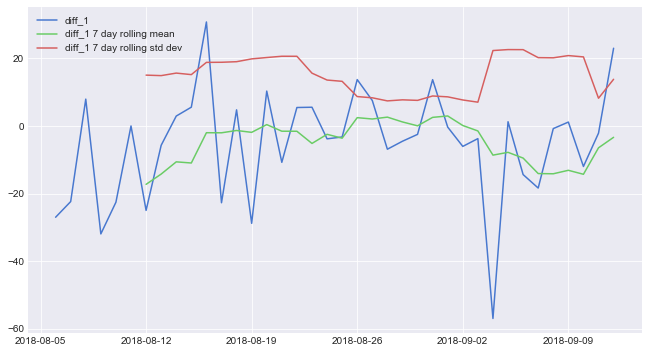


diff_1
adf=-6.510154885699868, npval=1.1055657285641474e-08
critical vals={'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}


In [8]:
window = 7

plt.figure(figsize=(11,6))
plt.plot(df_05.index.values,
         df_05.diff_1,
         label='diff_1')
plt.plot(df_05.index.values,
         df_05.diff_1.rolling(window).mean(),
         label='diff_1 {} day rolling mean'.format(window))
plt.plot(df_05.index.values,
         df_05.diff_1.rolling(window).std(),
         label='diff_1 {} day rolling std dev'.format(window))
plt.legend()
plt.show()

print('\ndiff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05.diff_1[2:])[0],
    adfuller(df_05.diff_1[2:])[1],
    adfuller(df_05.diff_1[2:])[4]))

<a id='acf_pacf'></a>
## Autocorrelation Functions (ACF/PACF)

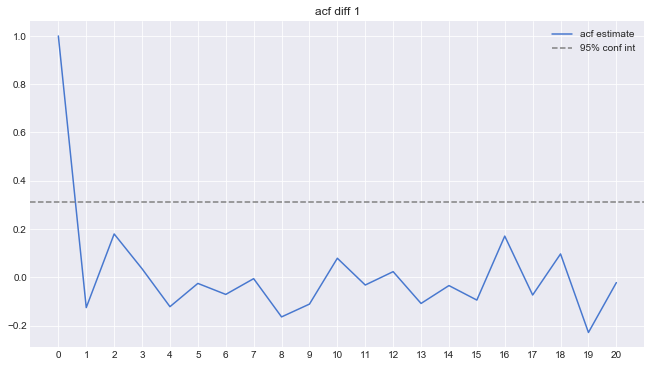

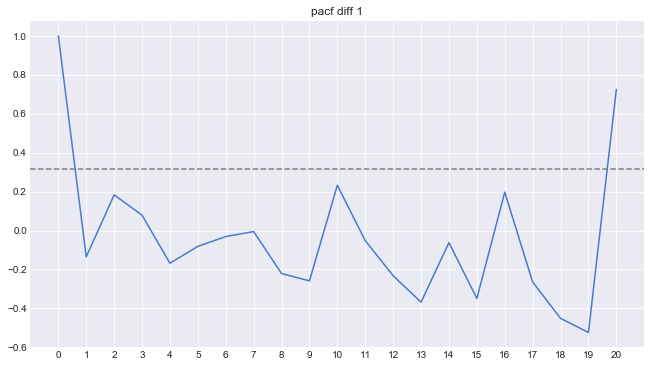

In [9]:
diff_1_acf = acf(df_05.diff_1[2:], nlags=20)
diff_1_pacf = pacf(df_05.diff_1[2:], nlags=20, method='ols')

plt.figure(figsize=(11,6))
plt.plot(diff_1_acf, label='acf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_05.diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('acf diff 1')
plt.legend()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(diff_1_pacf, label='pacf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_05.diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('pacf diff 1')
plt.show()

<a id='arima_modeling'></a>
## ARIMA Modeling

In [13]:
y = df_05.eth

def rmse(model):
    rmse = np.sqrt((model.resid ** 2).mean())
    return rmse

In [14]:
base = ARIMA(
    endog=y,
    order=(0,0,0)
).fit()
print(base.summary())
print('\nbase rmse = {}'.format(rmse(base)))

                              ARMA Model Results                              
Dep. Variable:                    eth   No. Observations:                   39
Model:                     ARMA(0, 0)   Log Likelihood                -208.323
Method:                           css   S.D. of innovations             50.535
Date:                Thu, 13 Sep 2018   AIC                            420.645
Time:                        18:59:02   BIC                            423.973
Sample:                    08-05-2018   HQIC                           421.839
                         - 09-12-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        278.5903      8.092     34.427      0.000     262.730     294.450

base rmse = 50.53514839209613


In [15]:
d1 = ARIMA(
    endog=y,
    order = (0,1,0)
).fit()
print(d1.summary())
print(rmse(d1))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   38
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -160.043
Method:                           css   S.D. of innovations             16.325
Date:                Thu, 13 Sep 2018   AIC                            324.085
Time:                        18:59:07   BIC                            327.360
Sample:                    08-06-2018   HQIC                           325.251
                         - 09-12-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2347      2.648     -1.977      0.056     -10.425      -0.044
16.32519778825006


In [16]:
ar1 = ARIMA(
    endog=y,
    order=(1,1,0)
).fit()
#ar1_res = ar1.fit()
print(ar1.summary())
print('\nar1 rmse = {}'.format(rmse(ar1)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   38
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -159.900
Method:                       css-mle   S.D. of innovations             16.262
Date:                Thu, 13 Sep 2018   AIC                            325.800
Time:                        18:59:07   BIC                            330.712
Sample:                    08-06-2018   HQIC                           327.548
                         - 09-12-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.2490      2.423     -2.166      0.037      -9.998      -0.500
ar.L1.D.eth    -0.0912      0.170     -0.536      0.596      -0.425       0.242
                                    Roots       

In [17]:
ma1 = ARIMA(
    endog=y,
    order=(0,1,1)
).fit()
print(ma1.summary())
print('\nma1 rmse = {}'.format(rmse(ma1)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   38
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -159.934
Method:                       css-mle   S.D. of innovations             16.278
Date:                Thu, 13 Sep 2018   AIC                            325.868
Time:                        18:59:08   BIC                            330.781
Sample:                    08-06-2018   HQIC                           327.616
                         - 09-12-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.2448      2.463     -2.129      0.040     -10.072      -0.418
ma.L1.D.eth    -0.0691      0.148     -0.468      0.642      -0.358       0.220
                                    Roots       

In [18]:
#combined = ARIMA(
#    endog=y,
#    order=(1,1,1)
#).fit()
#print(combined.summary())
#print('\ncombined rmse = {}'.format(rmse(combined)))

**Results:** Autoregressive or moving average components appear to be very small or non-existent for this data. Compared to a base model on first order differenced data, AR(1), MA(1) and combined order(1,1,1) models return higher (worse) AIC scores and non-significant coefficients. However, their RMSE's are slightly lower than the base model, though this is could be the result of some overfitting.

<a id='arima_forecasting'></a>
### Forecasting
- Forecast last 7 days of time series with d1 and ar1 models

In [19]:
y_train = y[:-7]
y_test = y[-7:]

start_date = y.index.values[-7]
end_date = y.index.values[-1]

In [20]:
d1 = ARIMA(
    endog=y_train,
    order=(0,1,0)
).fit()

d1_pred = d1.predict(
    start=start_date,
    end=end_date
)

d1f = d1.forecast(steps=7)
d1f_resid = d1f[0] - y_test
d1f_rmse = np.sqrt((d1f_resid ** 2).mean())

In [21]:
ar1 = ARIMA(
    endog=y_train,
    order=(1,1,0)
).fit()

ar1_pred = ar1.predict(
    start=start_date,
    end=end_date
)

ar1f = ar1.forecast(steps=7)
ar1f_resid = ar1f[0] - y_test
ar1f_rmse = np.sqrt((ar1f_resid ** 2).mean())

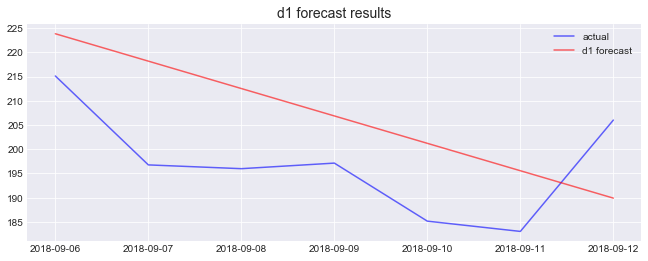

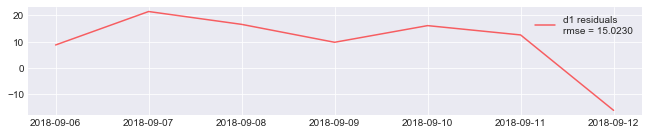

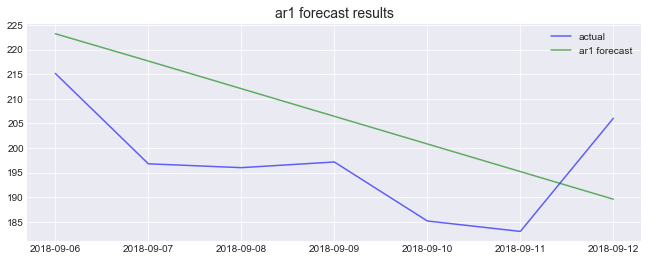

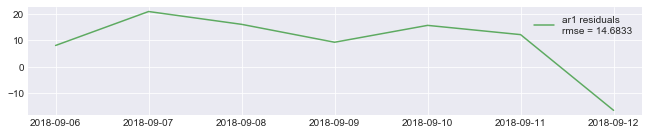

In [22]:
# plot results
alpha=.6

# d1 forecast results
plt.figure(figsize=(11,4))
plt.title('d1 forecast results', size=14)
plt.plot(
    df_05.index.values[-7:],
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    df_05.index.values[-7:],
    d1f[0],
    label='d1 forecast',
    color='red',
    alpha=alpha
)
plt.legend()
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    df_05.index.values[-7:],
    d1f_resid,
    label='d1 residuals\nrmse = {:.4f}'.format(d1f_rmse),
    color='red',
    alpha=alpha
)
plt.legend()
plt.show()

# ar1 forecast results
plt.figure(figsize=(11,4))
plt.title('ar1 forecast results', size=14)
plt.plot(
    df_05.index.values[-7:],
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    df_05.index.values[-7:],
    ar1f[0],
    label='ar1 forecast',
    color='green',
    alpha=alpha
)
plt.legend()
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    df_05.index.values[-7:],
    ar1f_resid,
    label='ar1 residuals\nrmse = {:.4f}'.format(ar1f_rmse),
    color='green',
    alpha=alpha
)
plt.legend()
plt.show()

<a id='exog'></a>
## Exogenous Variables
- Ethereum related
    - high
    - low
    - open
    - volume
    - market cap (need to get this working)
- Other Indices (exclude for now need to get current data)
    - VIX
    - DXY
    - EFFR
- Other Cryptocurrencies
    - BTC: Bitcoin
    - XRP: Ripple
    - EOS: EOS.IO
    - LTC: Litecoin
    - XLM: Stellar (need to figure out why its not pulling first values but where I'm working is correct)
    - XMR: Monero

In [23]:
# set df for ts with exogenous variables
dfx = df_orig.copy()
dfx.rename(columns={'eth_close':'eth'}, inplace=True)

# start at the beginning of ethereum
dfx = dfx[dfx.eth.isnull().sum():]
dfx.set_index('date', inplace=True)
dfx.head()

,eth_open,eth_high,eth_low,eth,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr
date,,,,,,,,,,,,,,,
2015-08-06,0.6747,3.0,0.6747,3.00,123.93,371.79,277.89,0.008013,NaN,4.10,NaN,0.7500,13.77,118.1833,0.14
2015-08-07,3.0000,3.0,0.1500,1.20,2119.43,1438.16,258.60,0.009000,NaN,3.77,NaN,0.7500,13.39,118.1833,0.14
2015-08-08,1.2000,1.2,1.2000,1.20,0.00,0.00,263.87,0.008700,NaN,3.87,NaN,0.7500,13.39,118.1833,0.14
2015-08-09,1.2000,1.2,1.2000,1.20,0.00,0.00,263.30,0.009180,NaN,3.88,NaN,0.4969,13.39,118.1833,0.14
2015-08-10,1.2000,1.2,0.6504,0.99,9486.09,7419.73,269.03,0.008500,NaN,4.08,NaN,0.4969,12.23,118.1833,0.14


In [24]:
# split on changepoints returned earlier
dfx_05 = dfx[cpts[3]:]

# check for missingness, applies more for broader date ranges
# than working with here, for example eos came out in jan 2018
print(dfx_05.isnull().sum())

eth_open          0
eth_high          0
eth_low           0
eth               0
eth_volumefrom    0
eth_volumeto      0
btc               0
xrp               0
eos               0
ltc               0
xlm               0
xmr               0
vixcls            0
twexb             0
effr              0
dtype: int64


In [25]:
len(dfx_05)

39

<a id='exog_modeling'></a>
## Modeling with Exogenous Variables

In [26]:
X = dfx_05.loc[:, ~(dfx_05.columns).isin(['eth'])]
#X = X.astype(float)
y = dfx_05.eth

In [27]:
basex = ARIMA(
    endog=y,
    exog=X,
    order=(0,0,0)
).fit(trend='nc')
print(basex.summary())
print('\nbasex rmse = {}'.format(rmse(basex)))

                              ARMA Model Results                              
Dep. Variable:                    eth   No. Observations:                   39
Model:                     ARMA(0, 0)   Log Likelihood                -107.028
Method:                           css   S.D. of innovations              3.764
Date:                Thu, 13 Sep 2018   AIC                            244.057
Time:                        18:59:17   BIC                            269.010
Sample:                    08-05-2018   HQIC                           253.010
                         - 09-12-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
eth_open          -0.1174      0.088     -1.342      0.192      -0.289       0.054
eth_high          -0.0889      0.098     -0.908      0.373      -0.281       0.103
eth_low            1.0423      0.047

In [28]:
d1x = ARIMA(
    endog=y,
    exog=X,
    order=(0,1,0)
).fit(trend='nc')
print(d1x.summary())
print('\nd1x rmse = {}'.format(rmse(d1x)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   38
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -97.462
Method:                           css   S.D. of innovations              3.145
Date:                Thu, 13 Sep 2018   AIC                            224.923
Time:                        18:59:24   BIC                            249.487
Sample:                    08-06-2018   HQIC                           233.663
                         - 09-12-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
eth_open          -1.0988      0.073    -15.084      0.000      -1.242      -0.956
eth_high          -0.0216      0.083     -0.259      0.798      -0.185       0.142
eth_low            0.9974      0.045

In [29]:
ar1x = ARIMA(
    endog=y,
    exog=X,
    order=(1,1,0)
).fit(trend='nc')
print(ar1x.summary())
print('\nar1x rmse = {}'.format(rmse(ar1x)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   38
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -96.206
Method:                       css-mle   S.D. of innovations              3.040
Date:                Thu, 13 Sep 2018   AIC                            224.411
Time:                        18:59:28   BIC                            250.612
Sample:                    08-06-2018   HQIC                           233.733
                         - 09-12-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
eth_open          -1.0988      0.074    -14.914      0.000      -1.243      -0.954
eth_high          -0.0216      0.080     -0.270      0.790      -0.178       0.135
eth_low            0.9974      0.055

In [30]:
ma1x = ARIMA(
    endog=y,
    exog=X,
    order=(0,1,1)
).fit(trend='nc')
print(ma1x.summary())
print('\nma1x rmse = {}'.format(rmse(ma1x)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   38
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -95.737
Method:                       css-mle   S.D. of innovations              3.002
Date:                Thu, 13 Sep 2018   AIC                            223.473
Time:                        18:59:32   BIC                            249.675
Sample:                    08-06-2018   HQIC                           232.796
                         - 09-12-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
eth_open          -1.0988      0.074    -14.895      0.000      -1.243      -0.954
eth_high          -0.0216      0.075     -0.286      0.778      -0.169       0.126
eth_low            0.9974      0.044

In [31]:
combinedx = ARIMA(
    endog=y,
    exog=X,
    order=(1,1,1)
).fit(trend='nc')
print(combinedx.summary())
print('\ncombinedx rmse = {}'.format(rmse(combinedx)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -94.711
Method:                       css-mle   S.D. of innovations              2.906
Date:                Thu, 13 Sep 2018   AIC                            223.423
Time:                        18:59:40   BIC                            251.262
Sample:                    08-06-2018   HQIC                           233.328
                         - 09-12-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
eth_open          -1.0988      0.073    -15.083      0.000      -1.242      -0.956
eth_high          -0.0216      0.090     -0.239      0.814      -0.199       0.155
eth_low            0.9974      0.060

**Results**: 

<a id='exog_forecasting'></a>
### Forecasting

In [32]:
# forecast last 7 days of series
X_train = X[:-7]
y_train = y[:-7]

X_test = X[-7:]
y_test = y[-7:]

In [41]:
d1x = ARIMA(
    endog=y_train,
    exog=X_train,
    order=(0,1,0)
).fit(trend='nc')

d1xf = d1x.forecast(steps=7, exog=X_test)
d1xf_resid = d1xf[0] - y_test
d1xf_rmse = np.sqrt((d1xf_resid ** 2).mean())

In [42]:
ar1x = ARIMA(
    endog=y_train,
    exog=X_train,
    order=(1,1,0)
).fit(trend='nc')

ar1xf = ar1x.forecast(steps=7, exog=X_test)
ar1xf_resid = ar1xf[0] - y_test
ar1xf_rmse = np.sqrt((ar1xf_resid ** 2).mean())

In [43]:
ma1x = ARIMA(
    endog=y_train,
    exog=X_train,
    order=(0,1,1)
).fit(trend='nc')

ma1xf = ma1x.forecast(steps=7, exog=X_test)
ma1xf_resid = ma1xf[0] - y_test
ma1xf_rmse = np.sqrt((ma1xf_resid ** 2).mean())

In [44]:
#combinedx = ARIMA(
#    endog=y_train,
#    exog=X_train,
#    order=(1,1,1)
#).fit(trend='nc')

#combinedx = combinedx.forecast(steps=7, exog=X_test)
#combinedx_resid = combinedx[0] - y_test
#combinedx_rmse = np.sqrt((combinedx_resid ** 2).mean())

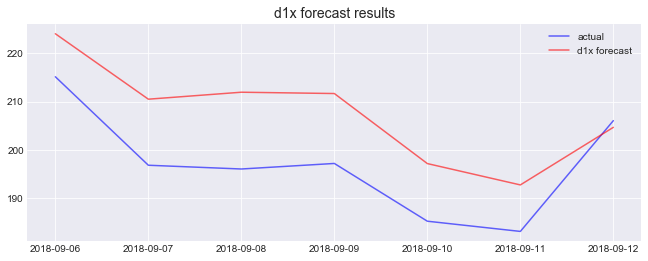

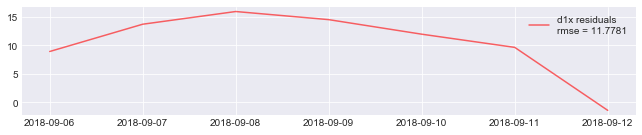

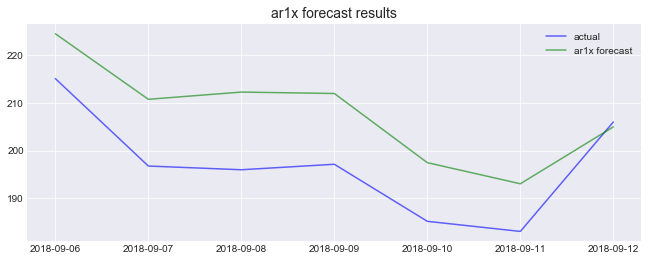

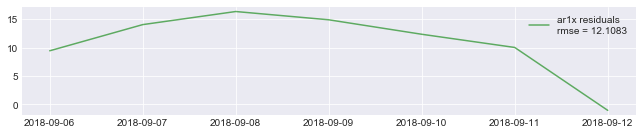

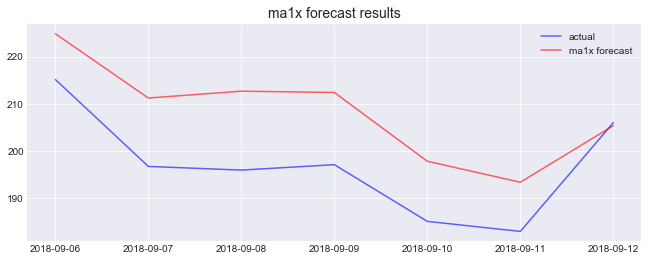

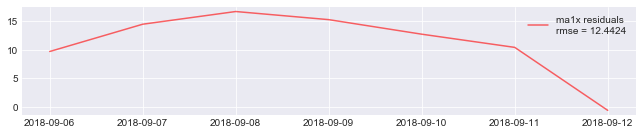

In [51]:
# plot results
alpha=.6

# d1x forecast results
plt.figure(figsize=(11,4))
plt.title('d1x forecast results', size=14)
plt.plot(
    dfx_05.index.values[-7:],
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    dfx_05.index.values[-7:],
    d1xf[0],
    label='d1x forecast',
    color='red',
    alpha=alpha
)
plt.legend()
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    dfx_05.index.values[-7:],
    d1xf_resid,
    label='d1x residuals\nrmse = {:.4f}'.format(d1xf_rmse),
    color='red',
    alpha=alpha
)
plt.legend()
plt.show()

# ar1x forecast results
plt.figure(figsize=(11,4))
plt.title('ar1x forecast results', size=14)
plt.plot(
    dfx_05.index.values[-7:],
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    dfx_05.index.values[-7:],
    ar1xf[0],
    label='ar1x forecast',
    color='green',
    alpha=alpha
)
plt.legend()
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    dfx_05.index.values[-7:],
    ar1xf_resid,
    label='ar1x residuals\nrmse = {:.4f}'.format(ar1xf_rmse),
    color='green',
    alpha=alpha
)
plt.legend()
plt.show()

# ma1x forecast results
plt.figure(figsize=(11,4))
plt.title('ma1x forecast results', size=14)
plt.plot(
    dfx_05.index.values[-7:],
    y_test,
    label='actual',
    color='blue',
    alpha=alpha
)
plt.plot(
    dfx_05.index.values[-7:],
    ma1xf[0],
    label='ma1x forecast',
    color='red',
    alpha=alpha
)
plt.legend()
plt.show()

plt.figure(figsize=(11,2))
plt.plot(
    dfx_05.index.values[-7:],
    ma1xf_resid,
    label='ma1x residuals\nrmse = {:.4f}'.format(ma1xf_rmse),
    color='red',
    alpha=alpha
)
plt.legend()
plt.show()